<a href="https://colab.research.google.com/github/ai-fast-track/icedata/blob/license-plates/license_plates.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/airctic/icevision/blob/master/notebooks/quickstart.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Note
This notebook is a work in progress document. We are sharing it with the IceVision Community through our Live Code Session (beginners-friendly). If you are interested in attending, please feel free to [join us](http://tinyurl.com/IceData)

# Creating a CSV Parser

This notebook shows how to parse the License Plates Dataset using a csv annotation file

## About the License Plates Dataset
The License Plates Dataset contains 237 images with one single classe:  'License_plate'

## Installing IceVision and IceData

In [ ]:
# !pip install icevision[all] icedata
!pip install git+git://github.com/airctic/icevision.git#egg=icevision[all] --upgrade -q

## Imports

In [3]:
from icevision.all import *

In [ ]:
# Loading Data
!wget https://github.com/ai-fast-track/icedata/releases/download/datasets/license_plates.zip

In [ ]:
!unzip license_plates.zip

In [7]:
import pandas as pd

# Read csv file. rename the "class" column with "label" to avoid conflicts
df = pd.read_csv('./license.csv')
df.sample(5)

Unnamed: 0                        image_name  ...  bottom_x  bottom_y
193         193  ../input/license/Cars/car193.jpg  ...  1.000000  0.756000
86           86   ../input/license/Cars/car86.jpg  ...  0.816327  0.724518
169         169  ../input/license/Cars/car169.jpg  ...  0.996000  0.796000
202         202  ../input/license/Cars/car202.jpg  ...  0.818000  0.933934
208         208  ../input/license/Cars/car208.jpg  ...  0.754000  0.723464

[5 rows x 6 columns]

### Define class_map

The dataset contains one single label: License_plate

In [19]:
class_map = ClassMap(["License_plate"])

In [20]:
class_map.get_name("License_plate")

1

In [21]:
class LicensePlateParser(parsers.FasterRCNN, parsers.FilepathMixin, parsers.SizeMixin):
    def __init__(self, df, source, class_map):
        self.df = df
        self.source = source
        self.class_map = class_map

    # def chexk_file(self, ):

    def __iter__(self):
        yield from self.df.itertuples()

    def __len__(self):
        return len(self.df)  

    def imageid(self, o) -> Hashable:
        return Path(o.image_name).stem

    def filepath(self, o) -> Union[str, Path]:
        fname = Path(o.image_name).name
        return Path(self.source) / fname

    def image_width_height(self, o) -> Tuple[int, int]:
        return get_image_size(self.filepath(o))

    def labels(self, o) -> List[int]:
        return [1]

    def bboxes(self, o) -> List[BBox]:
        w, h = get_image_size(self.filepath(o))
        xmin = o.top_x * w
        ymin = o.top_y * h
        xmax = o.bottom_x * w
        ymax = o.bottom_y * h
        return [BBox.from_xyxy(xmin, ymin, xmax, ymax)]

In [22]:
fname = Path("./Cars/car105.jpg") 
fname

Path('Cars/car105.jpg')

In [23]:
size = get_image_size(fname)
size

(750, 562)

## Parsing Data

In [24]:
# Parser
parser = LicensePlateParser(df, source="./Cars", class_map=class_map)

# Records
train_records, valid_records = parser.parse()

  0%|          | 0/237 [00:00<?, ?it/s]

WARNING  - Record with imageid: car107 was skipped because: File 'Cars/car107.jpg' does not exist | icevision.parsers.parser:parse_dicted:78
INFO     - Autofixing records | icevision.parsers.parser:parse:126


### Visualization
Showing a batch of images with their corresponding boxes and labels

In [25]:
train_records[0]

Record:
	- Image ID: 222
	- Filepath: Cars/car222.jpg
	- Image size (width, height): (500, 333)
	- Labels: [1]
	- BBoxes: [<BBox (xmin:141.0, ymin:220.99999999999974, xmax:351.00000000000006, ymax:272.9999999999998)>]

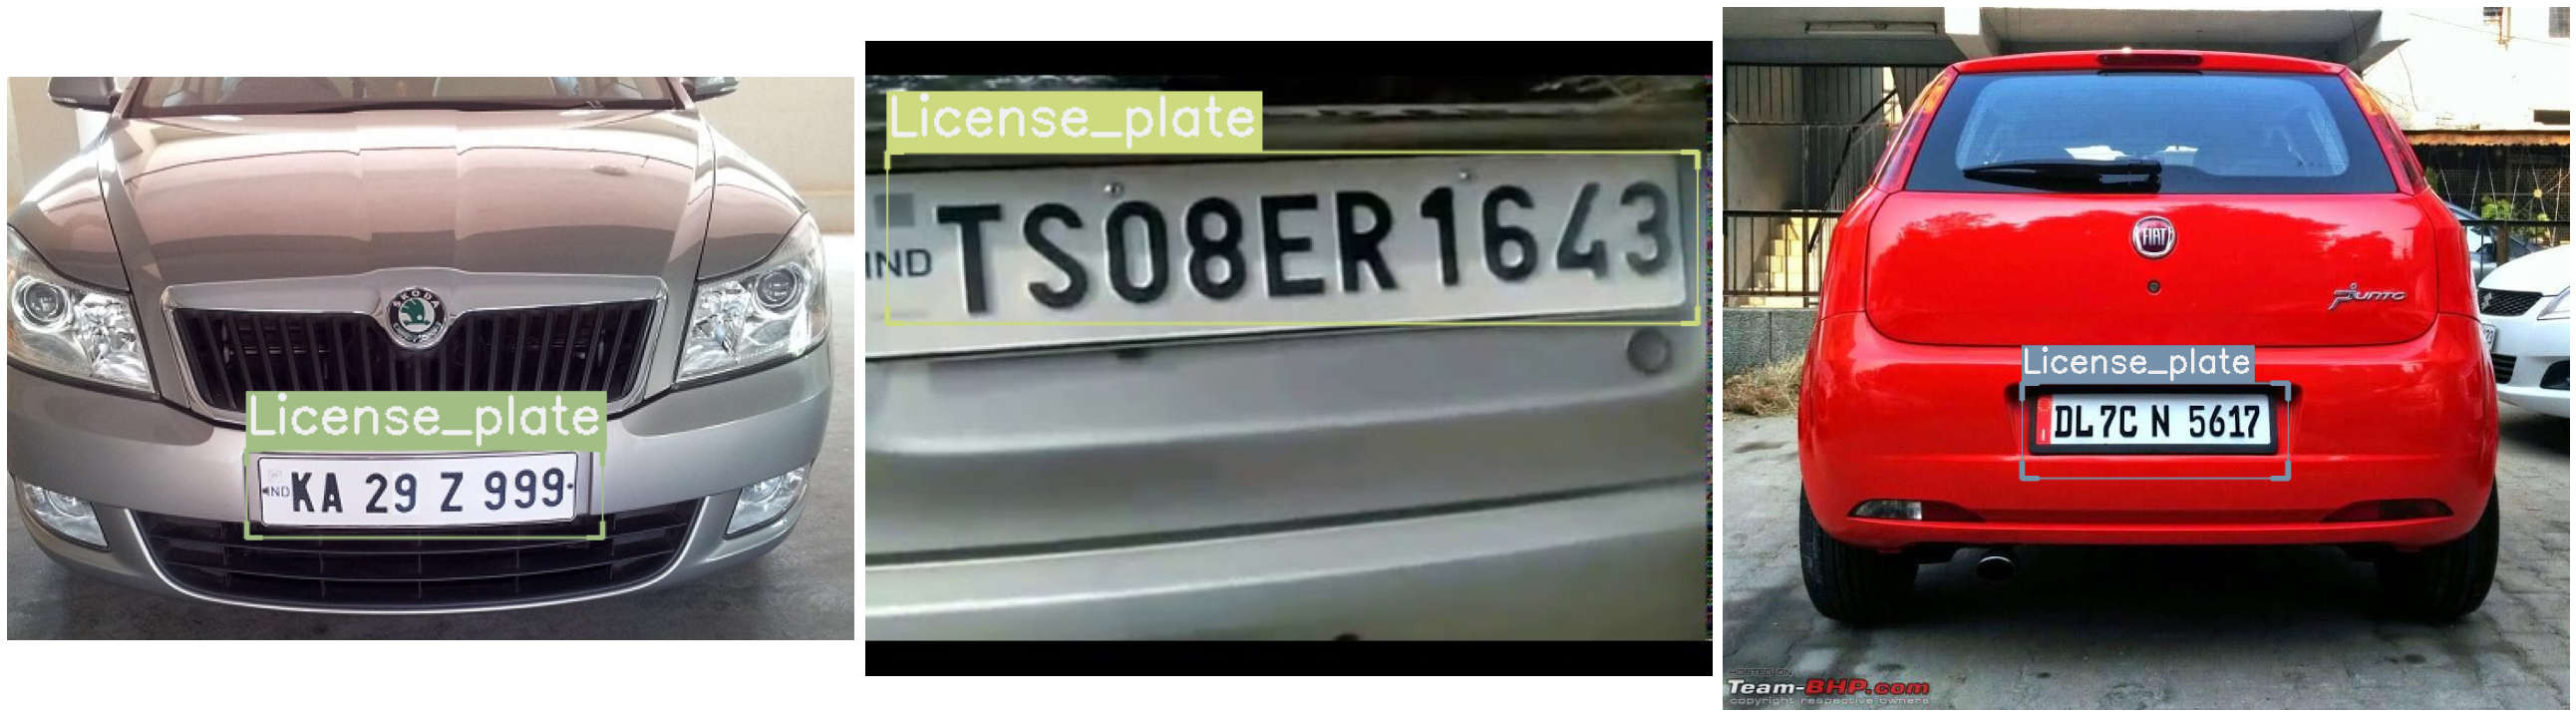

In [26]:
show_records(train_records[:3], ncols=3, class_map=class_map)

## Train and Validation Dataset Transforms

In [27]:
# Transforms
# size is set to 384 because EfficientDet requires its inputs to be divisible by 128
train_tfms = tfms.A.Adapter([*tfms.A.aug_tfms(size=384, presize=512), tfms.A.Normalize()])
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(384), tfms.A.Normalize()])

In [28]:
# Datasets
train_ds = Dataset(train_records, train_tfms)
valid_ds = Dataset(valid_records, valid_tfms)

### Displaying the same image with different transforms

Note:
> Transforms are applied **lazily**, meaning they are only applied when we grab (get) an item.
> This means that, if you have augmentation (random) transforms, each time you get the **same** item from 
> the dataset you will get a slightly different version of it.

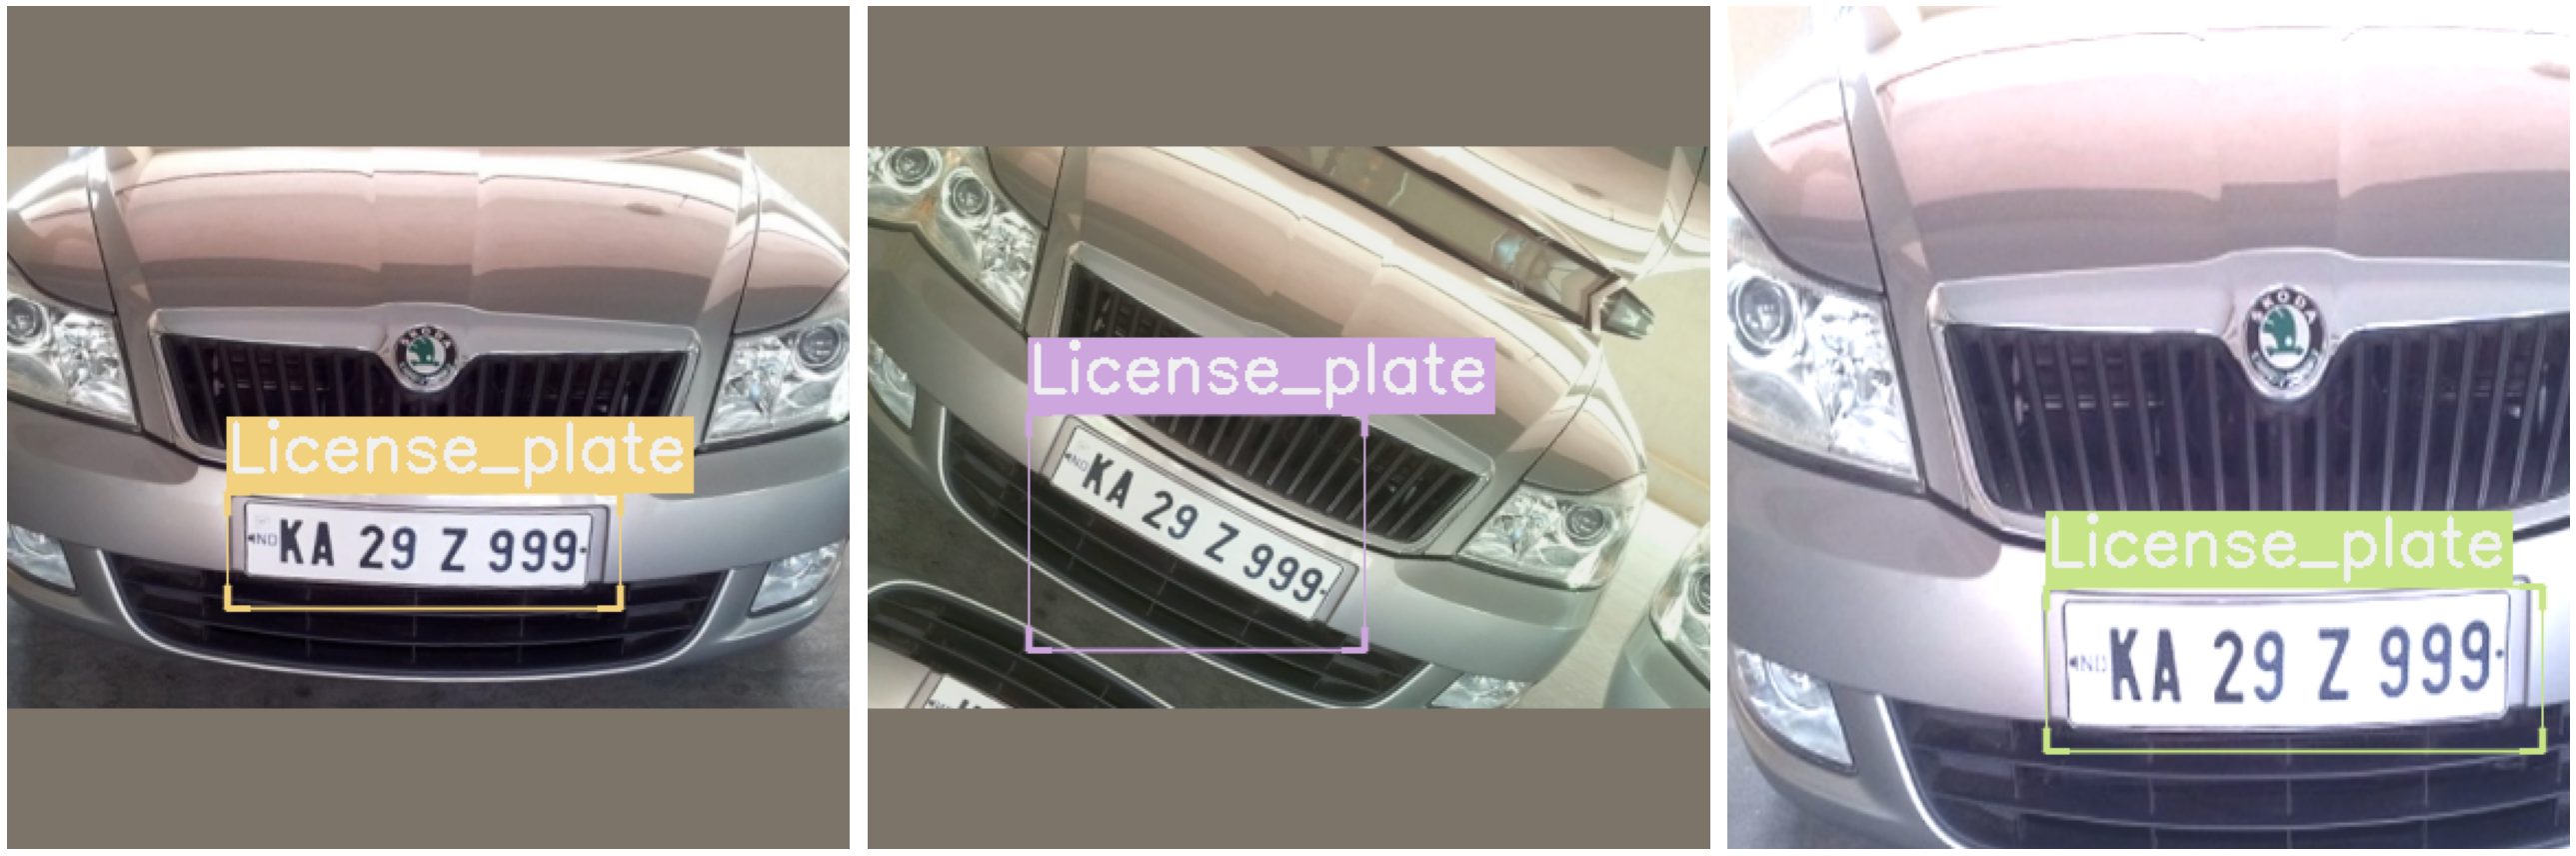

In [29]:
samples = [train_ds[0] for _ in range(3)]
show_samples(samples, ncols=3, class_map=class_map)

## DataLoader

In [30]:
# DataLoaders
train_dl = efficientdet.train_dl(train_ds, batch_size=16, num_workers=4, shuffle=True)
valid_dl = efficientdet.valid_dl(valid_ds, batch_size=16, num_workers=4, shuffle=False)

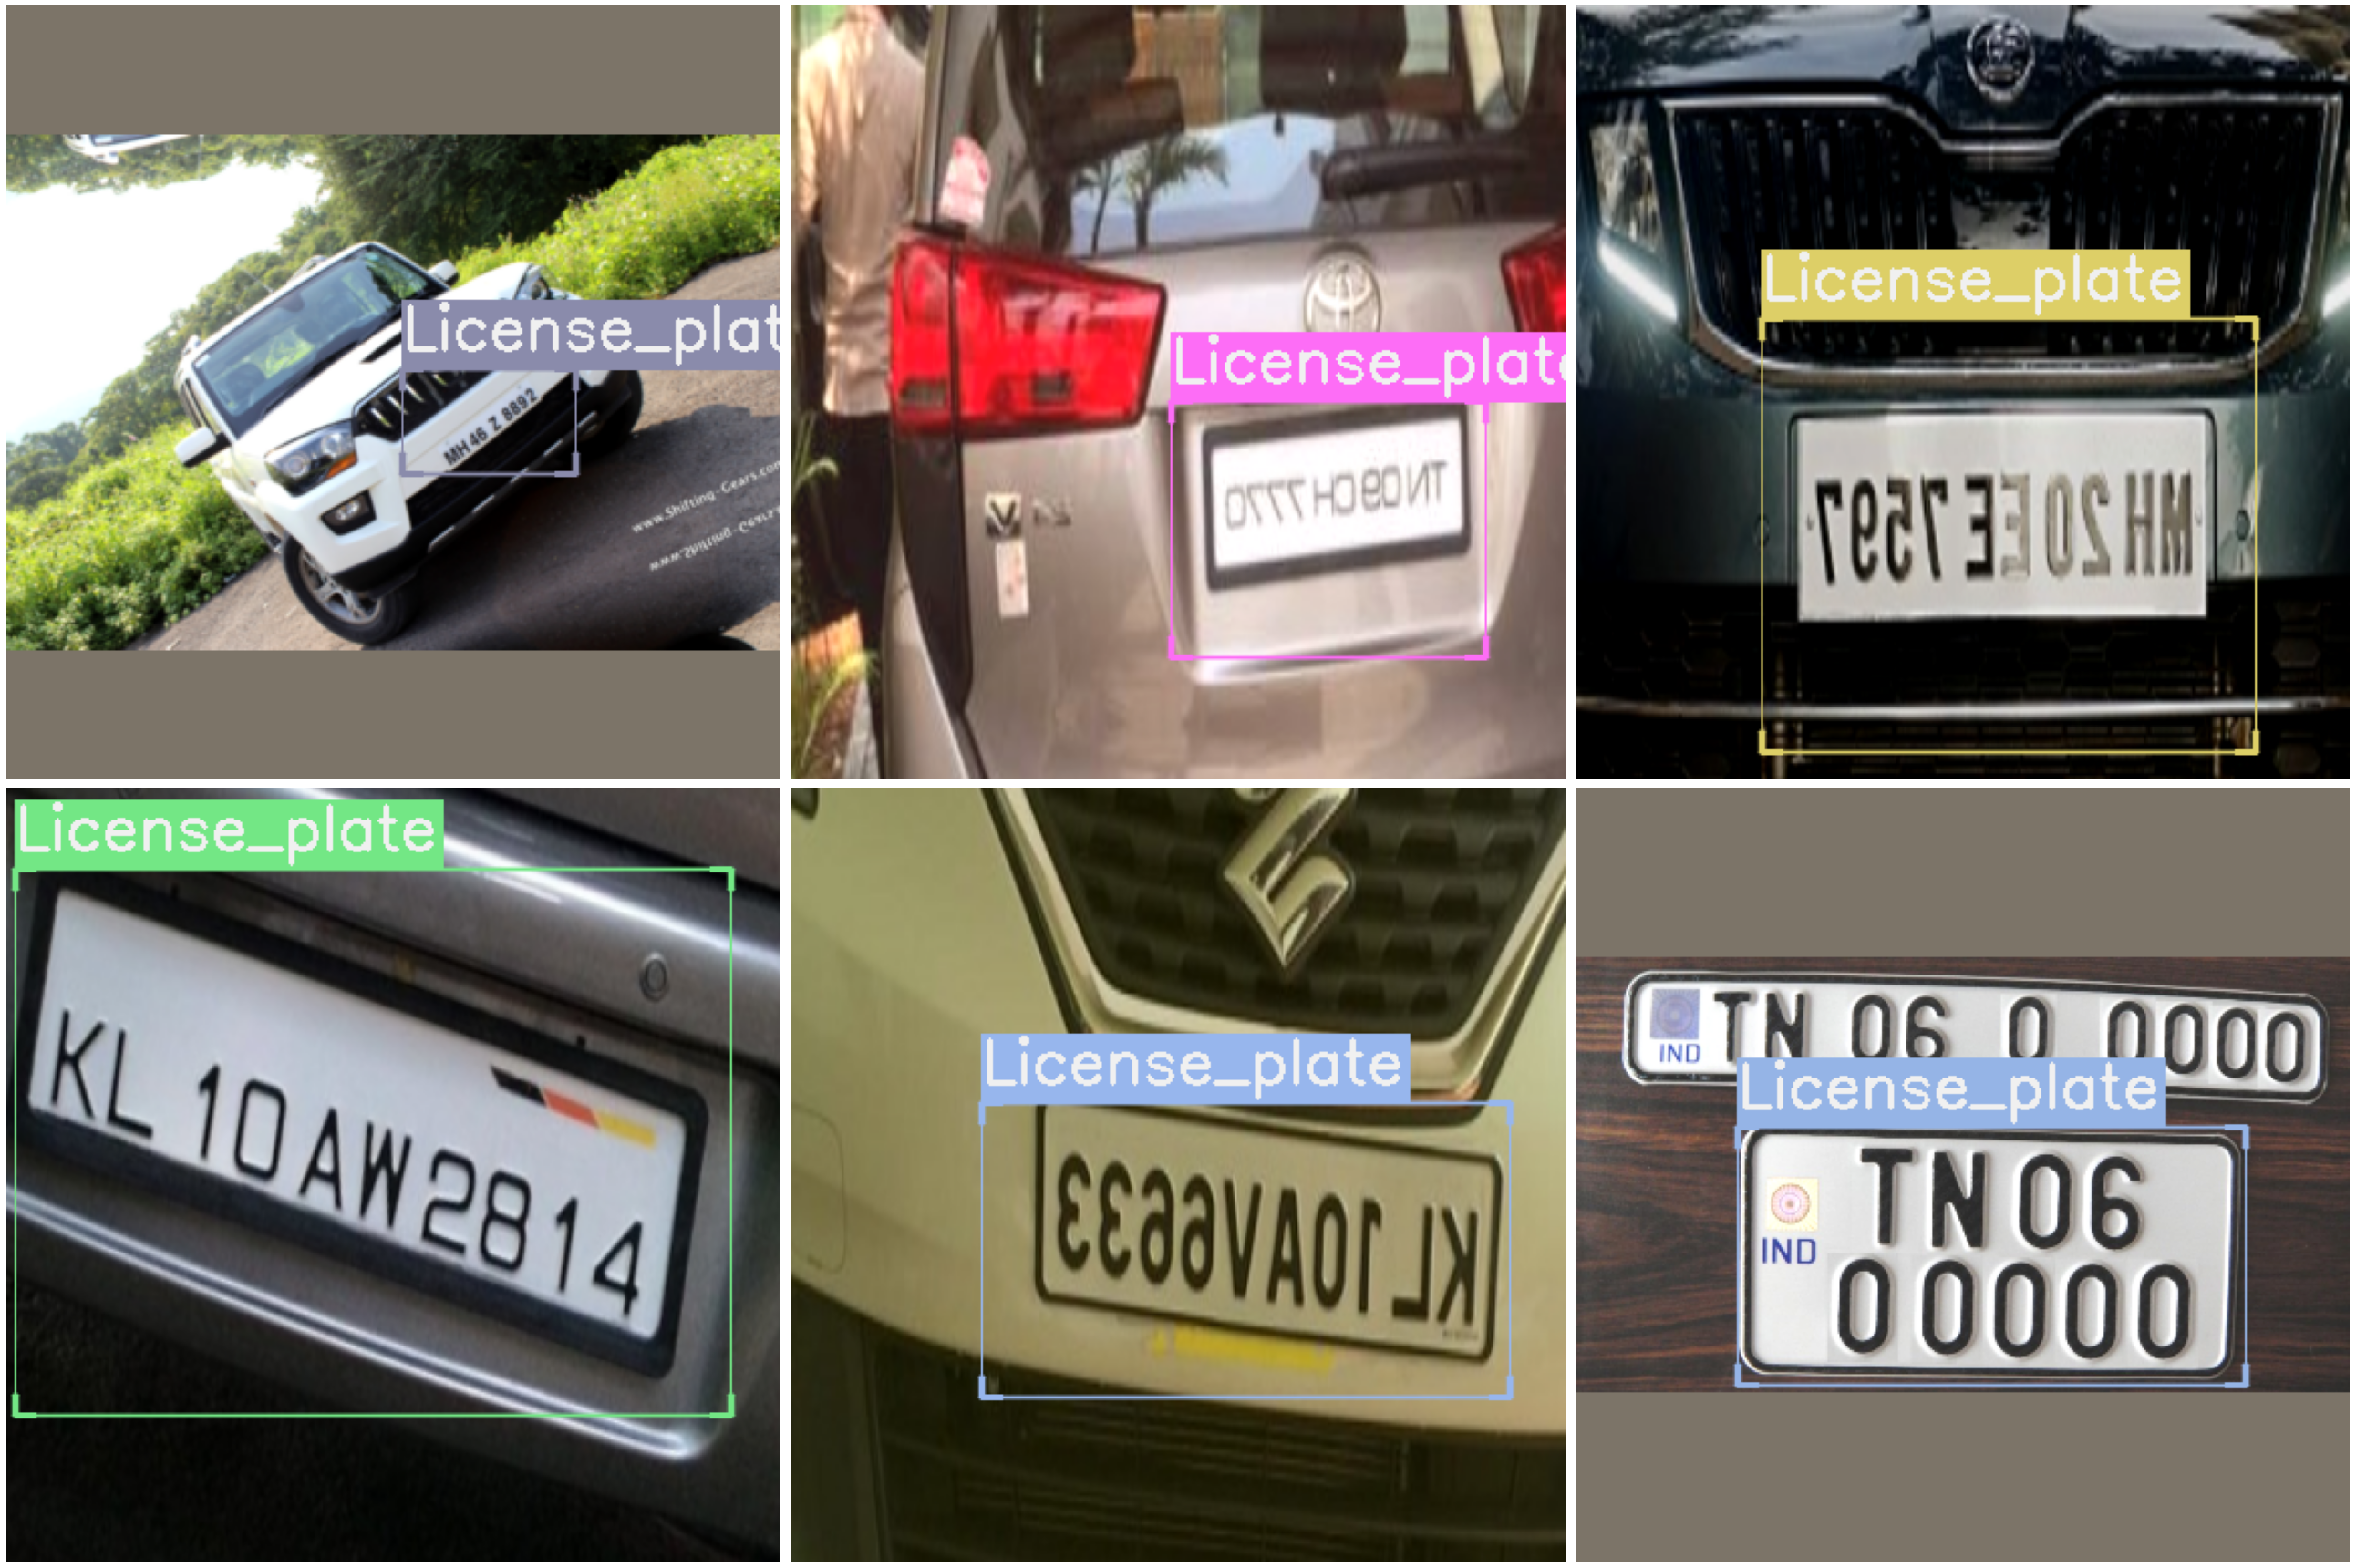

In [31]:
batch, samples = first(train_dl)
show_samples(samples[:6], class_map=class_map, ncols=3)

## Model

In [32]:
model = efficientdet.model(model_name="tf_efficientdet_lite0", num_classes=len(class_map), img_size=384)

Downloading: "https://github.com/rwightman/efficientdet-pytorch/releases/download/v0.1/tf_efficientdet_lite0-f5f303a9.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientdet_lite0-f5f303a9.pth


## Metrics

In [33]:
metrics = [COCOMetric(metric_type=COCOMetricType.bbox)]

## Training

IceVision is an agnostic framework meaning it can be plugged to other DL framework such as [fastai2](https://github.com/fastai/fastai2), and [pytorch-lightning](https://github.com/PyTorchLightning/pytorch-lightning).  

You could also plug to oth DL framework using your own custom code.

### Training using fastai

In [34]:
learn = efficientdet.fastai.learner(dls=[train_dl, valid_dl], model=model, metrics=metrics)

SuggestedLRs(lr_min=0.07585775852203369, lr_steep=0.6309573650360107)

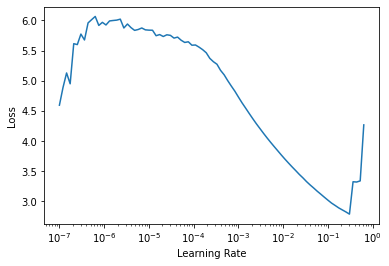

In [35]:
learn.freeze()
learn.lr_find()

In [ ]:
learn.fine_tune(50, 1e-2, freeze_epochs=1)

### Training using Lightning

In [ ]:
class LightModel(efficientdet.lightning.ModelAdapter):
    def configure_optimizers(self):
        return SGD(self.parameters(), lr=1e-2)
    
light_model = LightModel(model, metrics=metrics)

In [ ]:
trainer = pl.Trainer(max_epochs=50, gpus=1)
trainer.fit(light_model, train_dl, valid_dl)

## Inference

### Predicting a batch of images

Instead of predicting a whole list of images at one, we can process small batch at the time: This option is more memory efficient. 


In [40]:
infer_dl = efficientdet.infer_dl(valid_ds, batch_size=8)
samples, preds = efficientdet.predict_dl(model, infer_dl)

  0%|          | 0/6 [00:00<?, ?it/s]

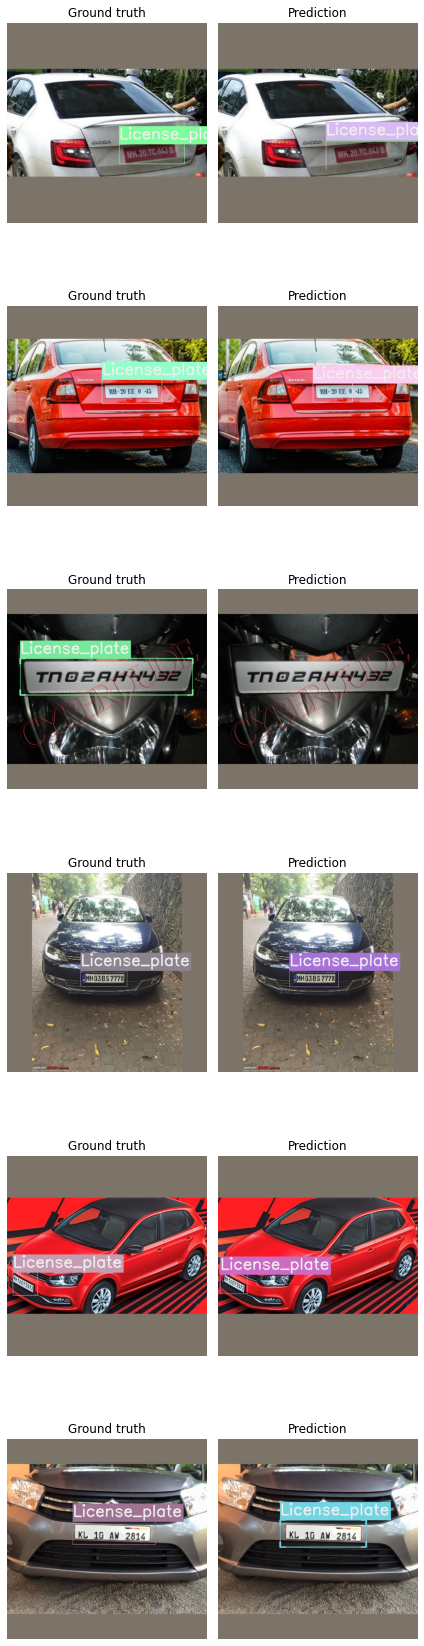

In [41]:
show_preds(
    samples=samples[:6],
    preds=preds[:6],
    class_map=class_map,
    denormalize_fn=denormalize_imagenet,
    ncols=3,
)

## Saving Model on Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = Path('/content/gdrive/My Drive/')

In [ ]:
torch.save(model.state_dict(), root_dir/'icevision/models/license_plates/license_plate_tf_efficientdet_lite0.pth')

## Happy Learning!

If you need any assistance, feel free to join our [forum](https://discord.gg/JDBeZYK).